# Penentuan K manual

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import nnls

# Load data
df = pd.read_csv("user_features_for_AA.csv")

# Simpan Steam ID, Total_Games, dan Total_Achievements untuk nanti digabungkan
id_col = df["Steam ID"]
total_games = df["Total_Games"]
total_achievements = df["Total_Achievements"]

# Ambil semua kolom numerik kecuali Steam ID
feature_cols = [col for col in df.columns if col != 'Steam ID']
X = df[feature_cols].values

# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Inisialisasi
n_samples, n_features = X_scaled.shape
n_archetypes = 4
np.random.seed(42)

# Random pilih k archetypes dari data sebagai awal
initial_indices = np.random.choice(n_samples, n_archetypes, replace=False)
Z = X_scaled[initial_indices]

# Alternating Minimization
max_iter = 100
tol = 1e-4
for iteration in range(max_iter):
    # Step 1: Update alpha (bobot tiap user terhadap archetype)
    A = np.zeros((n_samples, n_archetypes))
    for i in range(n_samples):
        A[i], _ = nnls(Z.T, X_scaled[i])

    # Step 2: Update Z (archetypes) dari alpha
    Z_new = np.zeros((n_archetypes, n_features))
    for j in range(n_archetypes):
        weights = A[:, j].reshape(-1, 1)
        if weights.sum() > 0:
            Z_new[j] = (weights * X_scaled).sum(axis=0) / weights.sum()
        else:
            Z_new[j] = Z[j]

    # Check konvergensi
    if np.linalg.norm(Z - Z_new) < tol:
        print(f"Konvergen di iterasi {iteration}")
        break
    Z = Z_new

# Susun hasil output sesuai format yang diinginkan
df_result = pd.DataFrame({
    "Steam ID": id_col,
    "Total_Games": total_games,
    "Total_Achievements": total_achievements
})

# Tambahkan bobot tiap archetype
for i in range(n_archetypes):
    df_result[f"Archetype_{i+1}_Weight"] = A[:, i]

# Simpan ke file
df_result.to_csv("archetypal_segments_k4.csv", index=False)
print("✅ Output akhir disimpan ke archetypal_segments_k4.csv")


Konvergen di iterasi 46
✅ Output akhir disimpan ke archetypal_segments_k4.csv


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import nnls

# Cell 1: Load preprocessed feature matrix
df = pd.read_csv("user_features_for_AA.csv")
steam_ids = df["Steam ID"]
total_games = df["Total_Games"]
total_achievements = df["Total_Achievements"]

# Cell 2: Prepare feature matrix X (all numeric columns except Steam ID)
feature_cols = [c for c in df.columns if c != "Steam ID"]
X = df[feature_cols].values

# Cell 3: Normalize features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Cell 4: Initialize Archetypal Analysis parameters
n_samples, n_features = X_scaled.shape
n_archetypes = 4
np.random.seed(42)

# pick initial archetypes randomly from data points
initial_indices = np.random.choice(n_samples, n_archetypes, replace=False)
Z = X_scaled[initial_indices, :].copy()

# Cell 5: Alternating minimization to estimate archetypes Z and weights A
max_iter = 100
tol = 1e-4
for iteration in range(max_iter):
    # 1) estimate A via non‑negative least squares for each sample
    A = np.zeros((n_samples, n_archetypes))
    for i in range(n_samples):
        A[i, :], _ = nnls(Z.T, X_scaled[i, :])

    # 2) update Z as weighted average of samples
    Z_new = np.zeros_like(Z)
    for j in range(n_archetypes):
        w = A[:, j].reshape(-1, 1)  # weights for archetype j
        if w.sum() > 0:
            Z_new[j, :] = (w * X_scaled).sum(axis=0) / w.sum()
        else:
            Z_new[j, :] = Z[j, :]
    # check convergence
    if np.linalg.norm(Z - Z_new) < tol:
        print(f"Converged at iteration {iteration}")
        Z = Z_new
        break
    Z = Z_new

# Cell 6: Normalize rows of A so each sums to 1 (convex combination)
A_norm = A / A.sum(axis=1, keepdims=True)

# Cell 7: Build result dataframe
df_result = pd.DataFrame({
    "Steam ID": steam_ids,
    "Total_Games": total_games,
    "Total_Achievements": total_achievements
})

# add normalized archetype weights (1-based naming)
for k in range(n_archetypes):
    df_result[f"Archetype_{k+1}_Weight"] = A_norm[:, k]

# Cell 8: Save to CSV
df_result.to_csv("archetypal_segments_k4_normalized.csv", index=False)
print("✅ Saved normalized archetype weights to 'archetypal_segments_k4_normalized.csv'")


Converged at iteration 46
✅ Saved normalized archetype weights to 'archetypal_segments_k4_normalized.csv'


# Cari nilai minimal RE (loop)

K=2, RE=12.2782
K=3, RE=11.6008
K=4, RE=10.9168
K=5, RE=10.5072
K=6, RE=10.1141
K=7, RE=9.6493
K=8, RE=9.1806
K=9, RE=8.9024
K=10, RE=8.5777

👉 Best K (min RE) = 10


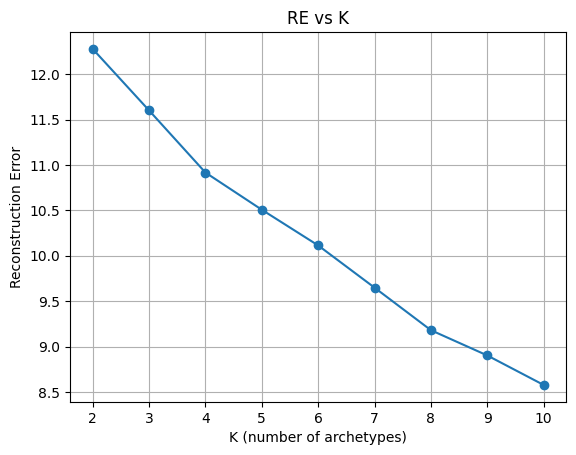

✅ Saved to 'archetypal_segments_normalized_bestK.csv' using K=10


In [18]:
# Cell 1: Load preprocessed feature matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import nnls

df = pd.read_csv("user_features_for_AA.csv")
steam_ids = df["Steam ID"]
total_games = df["Total_Games"]
total_achievements = df["Total_Achievements"]

# Cell 2: Prepare feature matrix X (all numeric columns except Steam ID)
feature_cols = [c for c in df.columns if c != "Steam ID"]
X = df[feature_cols].values

# Cell 3: Normalize features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Cell 4′: Evaluate Reconstruction Error for K=2…10 and pick best K
re_errors = []
Ks = list(range(2, 11))
n_samples, n_features = X_scaled.shape

for K in Ks:
    # initialize Z
    np.random.seed(42)
    init_idx = np.random.choice(n_samples, K, replace=False)
    Z = X_scaled[init_idx].copy()
    # alternating minimization
    for _ in range(100):
        A = np.zeros((n_samples, K))
        for i in range(n_samples):
            A[i], _ = nnls(Z.T, X_scaled[i])
        Z_new = np.zeros_like(Z)
        for j in range(K):
            w = A[:, j].reshape(-1,1)
            if w.sum()>0:
                Z_new[j] = (w * X_scaled).sum(axis=0) / w.sum()
            else:
                Z_new[j] = Z[j]
        if np.linalg.norm(Z-Z_new) < 1e-4:
            Z = Z_new
            break
        Z = Z_new
    # normalize A rows
    A_norm = A / A.sum(axis=1, keepdims=True)
    # compute RE
    X_hat = A_norm @ Z
    re = np.linalg.norm(X_scaled - X_hat)
    re_errors.append(re)
    print(f"K={K}, RE={re:.4f}")

best_K = Ks[int(np.argmin(re_errors))]
print(f"\n👉 Best K (min RE) = {best_K}")

# (opsional plot)
import matplotlib.pyplot as plt
plt.plot(Ks, re_errors, 'o-')
plt.xlabel("K (number of archetypes)")
plt.ylabel("Reconstruction Error")
plt.title("RE vs K")
plt.grid(True)
plt.show()

# Cell 5: Run AA with best_K
n_archetypes = best_K
np.random.seed(42)
init_idx = np.random.choice(n_samples, n_archetypes, replace=False)
Z = X_scaled[init_idx].copy()
for _ in range(100):
    A = np.zeros((n_samples, n_archetypes))
    for i in range(n_samples):
        A[i], _ = nnls(Z.T, X_scaled[i])
    Z_new = np.zeros_like(Z)
    for j in range(n_archetypes):
        w = A[:, j].reshape(-1,1)
        if w.sum()>0:
            Z_new[j] = (w * X_scaled).sum(axis=0) / w.sum()
        else:
            Z_new[j] = Z[j]
    if np.linalg.norm(Z-Z_new) < 1e-4:
        Z = Z_new
        break
    Z = Z_new

# Cell 6: Normalize rows of A so each sums to 1
A_norm = A / A.sum(axis=1, keepdims=True)

# Cell 7: Build and save result dataframe
df_result = pd.DataFrame({
    "Steam ID": steam_ids,
    "Total_Games": total_games,
    "Total_Achievements": total_achievements
})
for k in range(n_archetypes):
    df_result[f"Archetype_{k+1}_Weight"] = A_norm[:, k]

df_result.to_csv("archetypal_segments_normalized_bestK.csv", index=False)
print(f"✅ Saved to 'archetypal_segments_normalized_bestK.csv' using K={best_K}")



# Pakai Elbow

K=1, RSS=173.0454
K=2, RSS=150.7541
K=3, RSS=134.5791
K=4, RSS=119.1766
K=5, RSS=110.4020
K=6, RSS=102.2942
K=7, RSS=93.1086
K=8, RSS=84.2843
K=9, RSS=79.2528
K=10, RSS=73.5766
K=11, RSS=68.8746
K=12, RSS=60.9265
K=13, RSS=58.4994
K=14, RSS=51.9167
K=15, RSS=46.4475


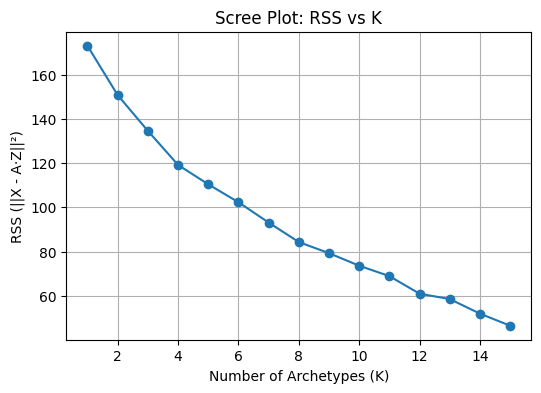

Elbow detected at K = 7
Using K = 7 for final analysis
✅ Saved to 'archetypal_segments_elbowK.csv'


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import nnls
import matplotlib.pyplot as plt
from kneed import KneeLocator

# ---------------------------
# Cell 1: Load & Prepare Data
# ---------------------------
df = pd.read_csv("user_features_for_AA.csv")
steam_ids = df["Steam ID"]
total_games = df["Total_Games"]
total_achievements = df["Total_Achievements"]

# select all feature columns (exclude Steam ID)
feature_cols = [c for c in df.columns if c != "Steam ID"]
X = df[feature_cols].values

# normalize to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------
# Cell 2: Define function to compute RE
# ---------------------------------------
def compute_re(X, K, max_iter=100, tol=1e-4):
    """
    Run AA with K archetypes (NNLS + alternating minimization)
    and return reconstruction error RE = ||X - A @ Z||_F.
    """
    n, d = X.shape
    rng = np.random.RandomState(42)
    replace_flag = (K > n)
    Z = X[rng.choice(n, K, replace=replace_flag)].copy()
    for _ in range(max_iter):
        # A-step: solve NNLS for each sample
        A = np.zeros((n, K))
        for i in range(n):
            A[i], _ = nnls(Z.T, X[i])
        # Z-step: update archetypes
        Z_new = np.zeros_like(Z)
        for j in range(K):
            w = A[:, j][:, None]
            if w.sum() > 0:
                Z_new[j] = (w * X).sum(axis=0) / w.sum()
            else:
                Z_new[j] = Z[j]
        if np.linalg.norm(Z - Z_new) < tol:
            Z = Z_new
            break
        Z = Z_new
    # normalize rows of A to sum=1
    A_norm = A / A.sum(axis=1, keepdims=True)
    # reconstruction
    X_hat = A_norm @ Z
    return np.linalg.norm(X - X_hat)

# --------------------------------------------------
# Cell 3: Scree Plot (RSS vs K) & Elbow Determination
# --------------------------------------------------
Ks = list(range(1, 16))   # test K = 1..15
rss = []
for K in Ks:
    re = compute_re(X_scaled, K)
    rss.append(re**2)
    print(f"K={K}, RSS={rss[-1]:.4f}")

# Plot Scree
plt.figure(figsize=(6,4))
plt.plot(Ks, rss, marker='o')
plt.xlabel("Number of Archetypes (K)")
plt.ylabel("RSS (||X - A·Z||²)")
plt.title("Scree Plot: RSS vs K")
plt.grid(True)
plt.show()

# automatic elbow detection
kl = KneeLocator(Ks, rss, curve='convex', direction='decreasing')
elbow_k = kl.elbow
print(f"Elbow detected at K = {elbow_k}")

# fallback if elbow not found
best_K = elbow_k or 4
print(f"Using K = {best_K} for final analysis")

# ----------------------------------------
# Cell 4: Final Archetypal Analysis (K=best_K)
# ----------------------------------------
n, d = X_scaled.shape
rng = np.random.RandomState(42)
replace_flag = (best_K > n)
Z = X_scaled[rng.choice(n, best_K, replace=replace_flag)].copy()
for _ in range(100):
    A = np.zeros((n, best_K))
    for i in range(n):
        A[i], _ = nnls(Z.T, X_scaled[i])
    Z_new = np.zeros_like(Z)
    for j in range(best_K):
        w = A[:, j][:, None]
        if w.sum() > 0:
            Z_new[j] = (w * X_scaled).sum(axis=0) / w.sum()
        else:
            Z_new[j] = Z[j]
    if np.linalg.norm(Z - Z_new) < 1e-4:
        Z = Z_new
        break
    Z = Z_new

# normalize final A
A_norm = A / A.sum(axis=1, keepdims=True)

# ---------------------------------
# Cell 5: Build & Save Final Result
# ---------------------------------
df_result = pd.DataFrame({
    "Steam ID": steam_ids,
    "Total_Games": total_games,
    "Total_Achievements": total_achievements
})
for k in range(best_K):
    df_result[f"Archetype_{k+1}_Weight"] = A_norm[:, k]

df_result.to_csv("archetypal_segments_elbowK.csv", index=False)
print("✅ Saved to 'archetypal_segments_elbowK.csv'")


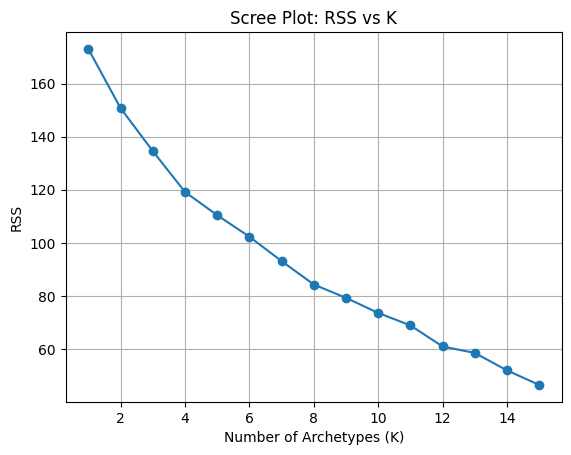

Elbow detected at K = 7
✅ Saved to 'archetypal_segments_elbowK_top3.csv' (K=7)


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import nnls
import matplotlib.pyplot as plt
from kneed import KneeLocator

# ---------------------------
# Cell 1: Load & Prepare Data
# ---------------------------
# 1a) Fitur AA
df_feats = pd.read_csv("user_features_for_AA.csv")
steam_ids    = df_feats["Steam ID"]
total_games  = df_feats["Total_Games"]
total_achiev = df_feats["Total_Achievements"]

# Siapkan matriks X untuk AA
X = df_feats.drop(columns=["Steam ID"]).values
X_scaled = MinMaxScaler().fit_transform(X)

# 1b) Data mentah untuk topik/genre
df_raw = pd.read_csv("transformation_segmentation.csv")

# Ekstrak Top 3 Topics per user
from collections import Counter
top3_topics = (
    df_raw
    .groupby("Steam ID")["Dominant_Topic"]
    .apply(lambda xs: [t for t,_ in Counter(xs).most_common(3)])
    .reset_index(name="Top_3_Topics")
)

# Ekstrak Top 3 Genres per user
top3_genres = (
    df_raw
    .groupby("Steam ID")["Dominant_Genre_Code"]
    .apply(lambda xs: [g for g,_ in Counter(xs).most_common(3)])
    .reset_index(name="Top_3_Genres")
)


# ---------------------------------------
# Cell 2: Define function to compute RE
# ---------------------------------------
def compute_re(X, K, max_iter=100, tol=1e-4):
    n, d = X.shape
    rng = np.random.RandomState(42)
    Z = X[rng.choice(n, K, replace=(K>n))].copy()
    for _ in range(max_iter):
        A = np.zeros((n, K))
        for i in range(n):
            A[i], _ = nnls(Z.T, X[i])
        Z_new = np.zeros_like(Z)
        for j in range(K):
            w = A[:, j][:, None]
            if w.sum()>0:
                Z_new[j] = (w * X).sum(axis=0)/w.sum()
            else:
                Z_new[j] = Z[j]
        if np.linalg.norm(Z - Z_new) < tol:
            Z = Z_new
            break
        Z = Z_new
    A_norm = A / A.sum(axis=1, keepdims=True)
    X_hat = A_norm.dot(Z)
    return np.linalg.norm(X - X_hat)

# --------------------------------------------------
# Cell 3: Scree plot & elbow detect
# --------------------------------------------------
Ks  = list(range(1, 16))
rss = []
for K in Ks:
    re = compute_re(X_scaled, K)
    rss.append(re**2)
plt.plot(Ks, rss, 'o-')
plt.xlabel("Number of Archetypes (K)")
plt.ylabel("RSS")
plt.title("Scree Plot: RSS vs K")
plt.grid(True)
plt.show()

kl      = KneeLocator(Ks, rss, curve="convex", direction="decreasing")
elbow_K = kl.elbow or 4
print(f"Elbow detected at K = {elbow_K}")

# ----------------------------------------
# Cell 4: Final AA with elbow_K
# ----------------------------------------
best_K = elbow_K
n, d   = X_scaled.shape
rng    = np.random.RandomState(42)
Z      = X_scaled[rng.choice(n, best_K, replace=(best_K>n))].copy()
for _ in range(100):
    A = np.zeros((n, best_K))
    for i in range(n):
        A[i], _ = nnls(Z.T, X_scaled[i])
    Z_new = np.zeros_like(Z)
    for j in range(best_K):
        w = A[:, j][:, None]
        Z_new[j] = (w * X_scaled).sum(axis=0)/w.sum() if w.sum()>0 else Z[j]
    if np.linalg.norm(Z - Z_new) < 1e-4:
        Z = Z_new
        break
    Z = Z_new
A_norm = A / A.sum(axis=1, keepdims=True)

# ---------------------------------
# Cell 5: Build & Save Final Result
# ---------------------------------
# mulai dari Steam ID, totals
df_out = pd.DataFrame({
    "Steam ID": steam_ids,
    "Total_Games": total_games,
    "Total_Achievements": total_achiev,
})

# tambahkan Top 3 Topic & Genre sebagai kolom terpisah
topics_df = pd.DataFrame(top3_topics["Top_3_Topics"].tolist(),
                         columns=["Top_1_Topic","Top_2_Topic","Top_3_Topic"])
genres_df = pd.DataFrame(top3_genres["Top_3_Genres"].tolist(),
                         columns=["Top_1_Genre","Top_2_Genre","Top_3_Genre"])
df_out = (
    df_out
    .merge(top3_topics, on="Steam ID")
    .merge(top3_genres, on="Steam ID")
    .drop(columns=["Top_3_Topics","Top_3_Genres"])
    .join(topics_df)
    .join(genres_df)
)

# tambahkan bobot arketipe
for k in range(best_K):
    df_out[f"Archetype_{k+1}_Weight"] = A_norm[:, k]

# simpan
df_out.to_csv("fix_result.csv", index=False)
print(f"✅ Saved to 'archetypal_segments_elbowK_top3.csv' (K={best_K})")


/Users/divaoncom/Library/Python/3.10/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/divaoncom/Library/Python/3.10/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


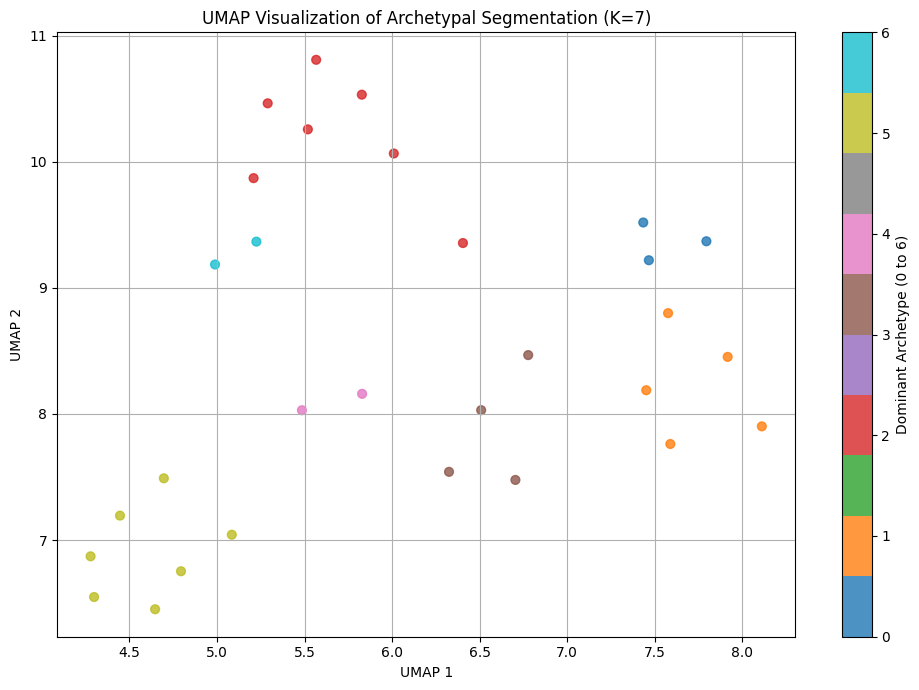

In [3]:
# 1. Import Library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import nnls
import matplotlib.pyplot as plt
import umap

# 2. Load Data & Siapkan Fitur
df_feats = pd.read_csv("user_features_for_AA.csv")
steam_ids    = df_feats["Steam ID"]
total_games  = df_feats["Total_Games"]
total_achiev = df_feats["Total_Achievements"]

# Buat matriks X dan normalisasi
X = df_feats.drop(columns=["Steam ID"]).values
X_scaled = MinMaxScaler().fit_transform(X)

# 3. Final Archetypal Analysis (K = 7)
best_K = 7
n, d   = X_scaled.shape
rng    = np.random.RandomState(42)
Z      = X_scaled[rng.choice(n, best_K, replace=(best_K > n))].copy()

for _ in range(100):
    A = np.zeros((n, best_K))
    for i in range(n):
        A[i], _ = nnls(Z.T, X_scaled[i])
    Z_new = np.zeros_like(Z)
    for j in range(best_K):
        w = A[:, j][:, None]
        Z_new[j] = (w * X_scaled).sum(axis=0)/w.sum() if w.sum() > 0 else Z[j]
    if np.linalg.norm(Z - Z_new) < 1e-4:
        Z = Z_new
        break
    Z = Z_new

# Hitung bobot partisipasi
A_norm = A / A.sum(axis=1, keepdims=True)

# 4. Visualisasi UMAP
dominant_archetypes = np.argmax(A_norm, axis=1)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(A_norm)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=dominant_archetypes, cmap='tab10', s=40, alpha=0.8)

plt.title("UMAP Visualization of Archetypal Segmentation (K=7)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Dominant Archetype (0 to 6)")
plt.grid(True)
plt.tight_layout()
plt.savefig("archetype_umap_k7.png", dpi=300)
plt.show()


In [27]:
output_json_path = "segmentation_result.json"
df_out.to_json(output_json_path, orient="records", force_ascii=False, indent=2)

print(f"✅ Saved JSON output to '{output_json_path}'")

✅ Saved JSON output to 'segmentation_result.json'


In [28]:
membership = []
threshold = 0.40

for k in range(best_K):
    col = f"Archetype_{k+1}_Weight"
    # pilih Steam ID dengan bobot ≥ threshold
    ids = df_out.loc[df_out[col] >= threshold, "Steam ID"].tolist()
    membership.append({
        "Archetype": k+1,
        "Member_Steam_IDs": ids
    })

membership_df = pd.DataFrame(membership)

# Simpan ke CSV
membership_df.to_csv("archetype_membership.csv", index=False)

print("✅ Saved archetype membership to 'archetype_membership.csv'")


✅ Saved archetype membership to 'archetype_membership.csv'
